### Initialization cell: run once on notebook start up

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time as tm, os
import uproot
from scipy.signal import find_peaks
from scipy.fft import fft
%matplotlib widget
myfigwidth = 12
plt.rcParams["figure.figsize"] = (myfigwidth,myfigwidth/2)

def tic():
    global startTime_for_tictoc
    startTime_for_tictoc = tm.perf_counter_ns()
    return

def toc():
    if 'startTime_for_tictoc' in globals():
        global most_recent_toc
        if most_recent_toc > startTime_for_tictoc: print("Toc Warning: Tic not reset.",end="  ")
        most_recent_toc = tm.perf_counter_ns()
        print (f"Elapsed time is {(most_recent_toc - startTime_for_tictoc)*1e-9:.3f} seconds.")
    else:
        print ("Toc Error: start time not set")
    return

def tocms():
    if 'startTime_for_tictoc' in globals():
        global most_recent_toc
        if most_recent_toc > startTime_for_tictoc: print("Toc Warning: Tic not reset.",end="  ")
        most_recent_toc = tm.perf_counter_ns()
        print (f"Elapsed time is {(most_recent_toc - startTime_for_tictoc)*1e-6:.3f} milliseconds.")
    else:
        print ("Toc Error: start time not set")
    return
global most_recent_toc
most_recent_toc = -666

# takes dataarray, 2 collumns of x and y points !!!assumes evenly spaced x points!!! 
#   averages every (2*downsampling + 1) data into single entry in new array
#   averages every (2*smoothing + 1) new array entries without downsampling
def downsmoother(dataarray,downsampling,smoothing):
    listlength = len(dataarray[1])
    downsmoothing = (downsampling*2 + 1)*(smoothing*2 + 1)
    
    downsmootharray = [dataarray[0][downsampling + (downsampling*2 + 1)*smoothing:listlength-(downsmoothing//2):(downsampling*2 + 1)]*1, 
                dataarray[1][:listlength-(downsmoothing - 1):(downsampling*2 + 1)]/downsmoothing]
    
    for shift in range(1,downsmoothing):
        downsmootharray[1] += dataarray[1][shift : listlength-(downsmoothing-1) + shift : (downsampling*2+1)]/downsmoothing
    return downsmootharray

### FFT & Peak Integration

In [17]:
#### Load file

inputfile=uproot.open("hiletgo/darksignals/output1919.root")
print(f"MIDAS run #{inputfile.keys()[-1][5:9]} loaded. \n\
Available events: {inputfile.keys()[-1][10:14]}")

# for generic csv formats:
#csvdata = np.loadtxt(str(textfilename + ".txt"),float)
#time = csvdata[:,0]
#signal = csvdata[:,1]

MIDAS run #1919 loaded. 
Available events: 6088


Original length: 25000 
Original integral: 4.116e+07

Downsampled/smoothed length: 4998 
Downsampled/smoothed integral: 4.114e+07


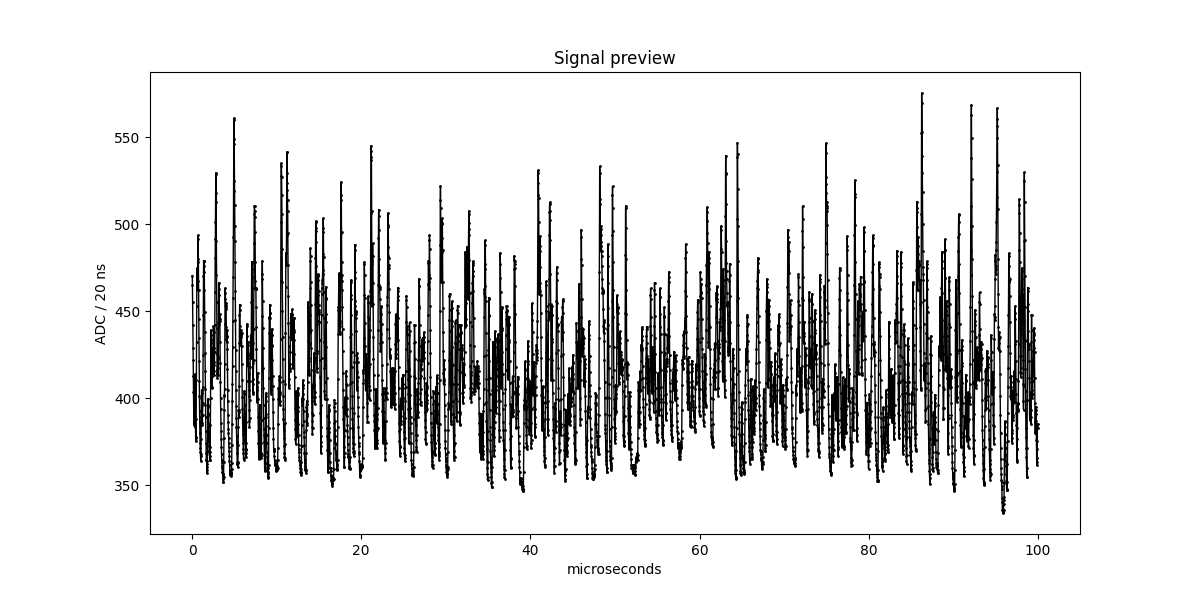

In [27]:
#### Define Inputs
startfreq = 12 #start window at frequency startfreq
hiresrange = 6 # window range

downsampling = 2  # average (2n+1) samples and rebin, retaining center bin time
smoothing = 1     # average (2n+1) samples without rebinning 
NyquistProtection = True
verbose = True

# Select individual sample to tune analysis parameters
samplenum = 12

#### Generate preview
ahist = inputfile[inputfile.keys()[samplenum]].values()
times = inputfile[inputfile.keys()[samplenum]].axis(0).edges()
signal = ahist
time = 0.5*(times[:-1]+times[1:])/1000
if (verbose): print(f"Original length: {len(time)} \nOriginal integral: {sum(signal)*(times[1]-times[0]):.3e}")
[time,signal] = downsmoother([time,signal],downsampling,smoothing)
if (verbose): print(f"\nDownsampled/smoothed length: {len(time)} \nDownsampled/smoothed integral: {sum(signal)*(time[1]-time[0])*1000:.3e}")

plt.close()
plt.plot(time,signal,marker=".",linewidth=1,markersize=2,color="black")
plt.title("Signal preview")
plt.xlabel("microseconds")
plt.ylabel(f"ADC / {(time[1]-time[0])*1000:.0f} ns")
#plt.xlim(0,10)
#plt.ylim(0,1000)
plt.show()

Calculating Fourier amplitudes...
Elapsed time is 1.564 milliseconds.
Window FFT max frequency: 12.13


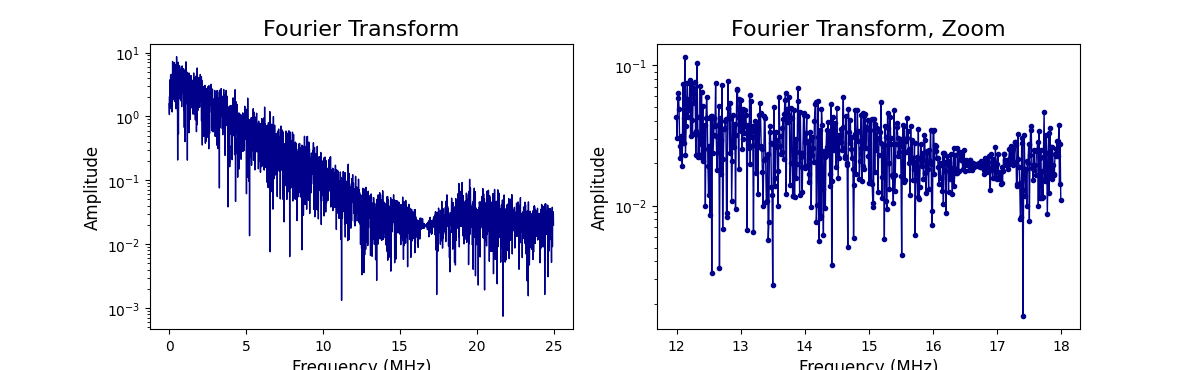

In [28]:
#### Calculate Fourier amplitudes
tic()
print("Calculating Fourier amplitudes...")

if (len(time)%2==0 and NyquistProtection):
    time = time[:-1]
    signal = signal[:-1]

T = time[-1] - time[0] #total integration period
N = len(time) #number of points
fftlength = N//2+1

# The DFT is always symmetric about its midpoint.
# Frequencies above the midpoint are below the Nyquist criterion and does not represent real frequencies.
scipyfft = fft(signal)[:fftlength]/(N//2+1/2)

FFTs = np.zeros([3,fftlength]) #Fourier frequencies, amplitudes, and phases
FFTs[0,:] = np.arange(fftlength)/T  #frequencies
FFTs[1,:] = abs(scipyfft)        #amplitudes
FFTs[2,:] = np.arctan2(np.imag(scipyfft),np.real(scipyfft))  #phases

tocms()


if (verbose):
    #  view specific spectral window
    hiresoff = round(startfreq*T)
    hiressamplepoints = round(hiresrange*T) # freq spacing is 1/T
    if (hiresoff>len(FFTs[0])):
        print(f"!! WARNING !! Window beyond Nyquist frequency, {FFTs[0,-1]:.2f} MHz; setting to very high pass")
        hiresoff = len(FFTs[0])-11
        hiressamplepoints = 10
    elif (hiressamplepoints+hiresoff)>len(FFTs[0]): 
        print(f"!! WARNING !! Window cut off at Nyquist frequency, {FFTs[0,-1]:.2f} MHz")
        hiressamplepoints = len(FFTs[0])-1-hiresoff

    FFTshr = np.zeros([3,hiressamplepoints]) #high res window
    FFTshr[0,:] = FFTs[0,hiresoff:hiresoff+hiressamplepoints]
    FFTshr[1,:] = FFTs[1,hiresoff:hiresoff+hiressamplepoints]
    FFTshr[2,:] = FFTs[2,hiresoff:hiresoff+hiressamplepoints]
    print(f"Window FFT max frequency: {FFTshr[0][np.argmax(FFTshr[1])]:.2f}")
    
    # Plot the Fourier spectrum
    plt.close()
    fig,ax = plt.subplots(1,2,figsize=(myfigwidth,myfigwidth/(1+np.sqrt(5))))
    if len(FFTs[0])>100: ax[0].plot(FFTs[0,1:],FFTs[1,1:] ,"-",linewidth=1,color="darkblue") #FFTs[1,:]
    else: ax[0].plot(FFTs[0,:],FFTs[1,:],"-",linewidth=1,marker=".",color="darkblue")

    ax[0].set_title("Fourier Transform", size=16)
    ax[0].set_xlabel("Frequency (MHz)", size=12)
    ax[0].set_ylabel("Amplitude", size=12)
    ax[0].set_yscale('log')
    #ax[0].set_xlim(0.3,0.4)
    #ax[0].set_ylim(0,5)

    ax[1].plot(FFTshr[0],FFTshr[1]*(N/2)/(N//2+1/2),"-",linewidth=1,marker=".",label="Amplitude",color="darkblue")
    ax[1].set_title("Fourier Transform, Zoom", size=16)
    ax[1].set_xlabel("Frequency (MHz)", size=12)
    ax[1].set_ylabel("Amplitude", size=12)
    ax[1].set_yscale('log')
    #ax[1].set_xlim(0.3,0.4)
    #ax[1].set_ylim(0,30)
    '''
    ax[1].legend(loc="upper right")
    axtwin = ax[1].twinx() 
    axtwin.plot(FFTshr[0],np.mod(FFTshr[2]/2/np.pi,1),"-",linewidth=1,marker=".",color="steelblue",label="phase")
    axtwin.legend(loc=(0.76,0.8))
    axtwin.set_ylabel("Phase", size=12)
    '''
    plt.show()

Calculating Inverse FFT...
Elapsed time is 7.028 milliseconds.


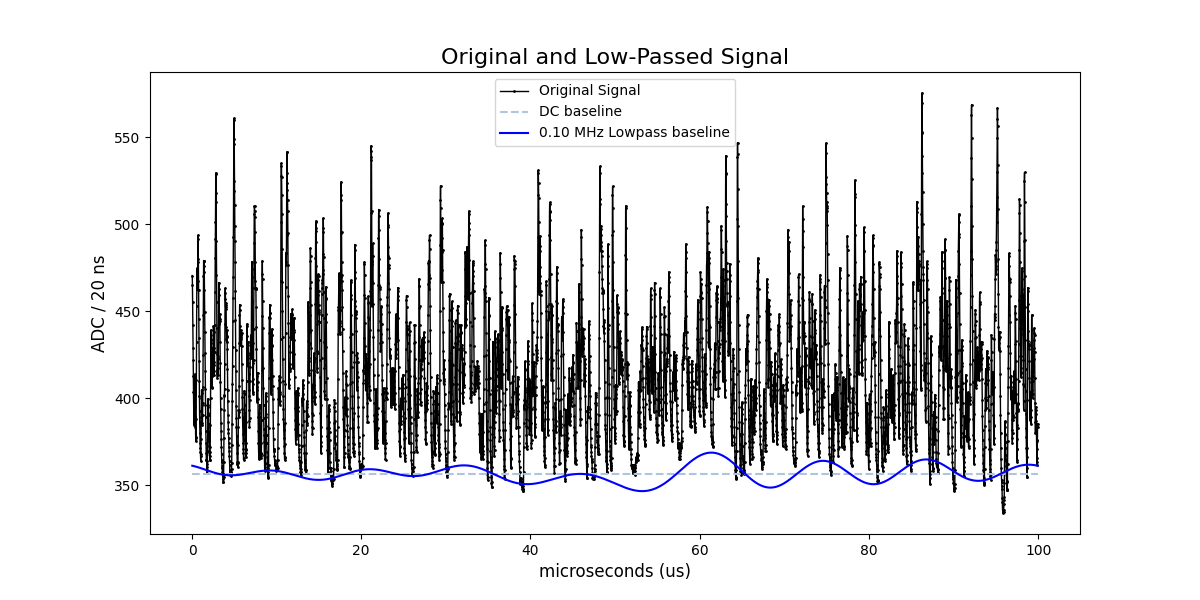

In [37]:
####  Select Lowpass removal
lowpasscut = 1/10
DCoffset = -55 # manual DC offset

#### Remove lowpass from original signal and compare
tic()
print("Calculating Inverse FFT...")

#lowpass
lowpasssamplepoints = round(lowpasscut*T)
if (N*lowpasssamplepoints)>1e8:
    print(f"!!! WARNING !!! Too many lowpass sample points ({N*lowpasssamplepoints:.2e}), risk of crash")
else:
    invexparray = np.exp(2j*np.pi/N* np.outer( np.arange(N),np.arange(lowpasssamplepoints) ))
    arrayfreqs = np.array([FFTs[1,:lowpasssamplepoints] * np.exp(1j*FFTs[2,:lowpasssamplepoints])] * N)

    invFTlp = np.sum(arrayfreqs * invexparray,1)
    ReinvFTlp = np.real(invFTlp) + np.mean(signal) - np.mean(np.real(invFTlp))
tocms()

plt.close()
plt.plot(time,signal,marker=".",linewidth=1,markersize=2,label = "Original Signal",color="black")
plt.plot([time[0],time[-1]],[np.mean(signal)+DCoffset,np.mean(signal)+DCoffset],"--",label="DC baseline",color='lightsteelblue')
plt.plot(time,ReinvFTlp+DCoffset,"-",label=f"{lowpasscut:.2f} MHz Lowpass baseline",color='blue')
#plt.plot(time,signal-ReinvFTlp+np.mean(signal),"--",label="FFT recon. window subtract")

plt.legend()
plt.title("Original and Low-Passed Signal", size=16)
plt.xlabel("microseconds (us)", size=12)
plt.ylabel(f"ADC / {(time[1]-time[0])*1000:.0f} ns", size=12)
#plt.xlim(0.6,1.1)
plt.show()

Number of peaks detected: 277
Average peak height: 93.1


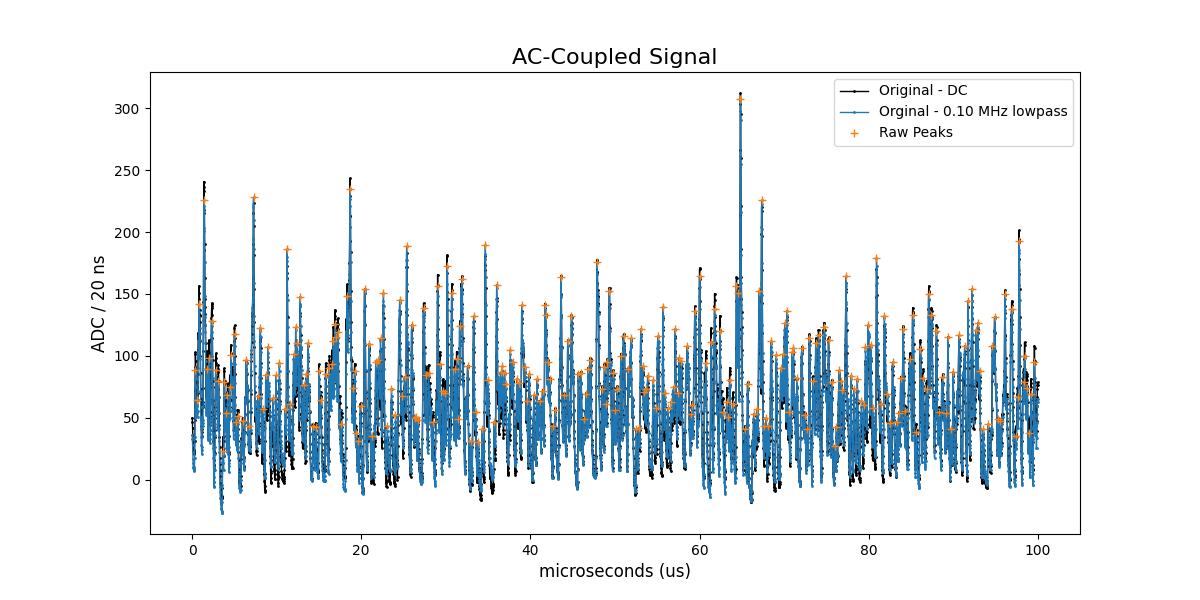

In [42]:
#### Select raw peak-finder parameters
rawpwidth = 3
rawpprom = 10

signal_down = signal-np.mean(signal,dtype="float64")-DCoffset
signal_lp = signal-ReinvFTlp-DCoffset

peaks,props = find_peaks(signal_lp,height=0,width=rawpwidth,prominence=rawpprom)

plt.close()
plt.plot(time,signal_down,marker=".",linewidth=1,markersize=2,label = "Original - DC",color="black")
plt.plot(time,signal_lp,marker=".",linewidth=1,markersize=2,label=f"Orginal - {lowpasscut:.2f} MHz lowpass")

plt.plot(time[peaks],signal_lp[peaks],marker="+",linewidth=0,label="Raw Peaks")
print(f"Number of peaks detected: {len(peaks)}\n\
Average peak height: {np.mean(signal_lp[peaks]):.1f}")
plt.legend()
plt.title("AC-Coupled Signal", size=16)
plt.xlabel("microseconds (us)", size=12)
plt.ylabel(f"ADC / {(time[1]-time[0])*1000:.0f} ns", size=12)
#plt.xlim(0,48)
plt.show()

In [ ]:
#### Select rolling integral windows to try
mywindows = [6,8,16]

plt.close()
plt.plot(time,signal_lp,label="Signal",marker=".",linewidth=1,markersize=2,color="black")

for window in mywindows:
    for shift in range(window):
        if shift == 0: 
            peakfind = 0.2*signal_lp[:len(signal_lp)+1-window] # divide by 5 for easier comparison to original data
        else: peakfind += 0.2*signal_lp[shift:len(signal_lp)+1-window+shift]
    plt.plot(time[:1-window],peakfind,label=f"Rolling Integral, {(time[window]-time[0])*1000:.0f} ns")

plt.legend()
plt.title("Rolling Integral Peak Detector", size=16)
plt.xlabel("microseconds (us)", size=12)
plt.ylabel("ADC Integral", size=12)
plt.xlim(0,12)
plt.show()
#sum(signal_lp[np.argmin(abs(time-mytime)):np.argmin(abs(time-mytime-mywindow))]),sum(signal_lp[0:-1])

In [ ]:
#### Select integral peak-finder parameters
mywindow = 6
pwidth = 2
pprom = 10

for shift in range(mywindow):
    if shift == 0: 
        peakfind = 1/5*signal_lp[:len(signal_lp)+1-mywindow]
    else: peakfind += 1/5*signal_lp[shift:len(signal_lp)+1-mywindow+shift]
    
peaks,props = find_peaks(peakfind,height=0,width=pwidth,prominence=pprom) #

print(f"Number of peaks detected: {len(peaks)}\n\
Average peak height: {np.mean(peakfind[peaks])}")
plt.close()
plt.plot(time,signal_down,label="Signal",marker=".",linewidth=1,markersize=2,color="black")
plt.plot(time[:1-mywindow],peakfind,label=f"Rolling Average, {mywindow} pts")
plt.plot(time[:1-mywindow][peaks],peakfind[peaks],marker="+",linewidth=0)
plt.legend()
plt.title("Integral Peaks", size=16)
plt.xlabel("microseconds (us)", size=12)
plt.ylabel("ADC Integral", size=12)
plt.xlim(0,12)
plt.show()

## Analyze full run

In [39]:
#### Input selected parameters from above
myset = "hiletgo55"
inputfile=uproot.open("hiletgo/darksignals/output1919.root")
totsamples = int(inputfile.keys()[-1][10:14])
#totsamples = 1000
lowpasscut = 1/10

if (myset == "raw1"):
    downsampling = 4
    smoothing = 0
    mywindow = [2,3,4]
    rawpwidth = 2
    rawpprom = 3
    pwidth = 2
    pprom = 9
    DCoff = 0
elif (myset == "hiletgo52"):
    downsampling = 3
    smoothing = 0
    mywindow = [6,8,10]
    rawpwidth = 3
    rawpprom = 3
    pwidth = 3
    pprom = 2
    DCoff = -6
elif (myset == "hiletgo55"):
    downsampling = 2
    smoothing = 1
    mywindow = [4,6,10]
    rawpwidth = 2
    rawpprom = 10
    pwidth = 2
    pprom = 10
    DCoff = -55
elif (myset == "hiletgo56"):
    downsampling = 3
    smoothing = 0
    mywindow = [6,8,10]
    rawpwidth = 5
    rawpprom = 20
    pwidth = 5
    pprom = 10
    DCoff = -82
else:
    print("WARNING!!!  Not a valid set!!")

rawpeaks = [-666]*totsamples
intpeaks_s = [-666]*totsamples
intpeaks_m = [-666]*totsamples
intpeaks_l = [-666]*totsamples

pbar = tqdm(total=totsamples,ascii=True,leave=False) 
tic()
for samplenum in range(totsamples):
    ahist = inputfile[inputfile.keys()[samplenum]].values()
    times = inputfile[inputfile.keys()[samplenum]].axis(0).edges()
    signal = ahist
    time = 0.5*(times[:-1]+times[1:])/1000
    [time,signal] = downsmoother([time,signal],downsampling,smoothing)
    
    T = time[-1] - time[0] #total integration period
    N = len(time) #number of points
    fftlength = N//2+1
    scipyfft = fft(signal)[:fftlength]/(N//2+1/2)
    FFTs = np.zeros([3,fftlength]) #Fourier frequencies, amplitudes, and phases
    FFTs[0,:] = np.arange(fftlength)/T  #frequencies
    FFTs[1,:] = abs(scipyfft)        #amplitudes
    FFTs[2,:] = np.arctan2(np.imag(scipyfft),np.real(scipyfft))  #phases
    
    lowpasssamplepoints = round(lowpasscut*T)
    invexparray = np.exp(2j*np.pi/N* np.outer( np.arange(N),np.arange(lowpasssamplepoints) ))
    arrayfreqs = np.array([FFTs[1,:lowpasssamplepoints] * np.exp(1j*FFTs[2,:lowpasssamplepoints])] * N)
    invFTlp = np.sum(arrayfreqs * invexparray,1)
    ReinvFTlp = np.real(invFTlp) + np.mean(signal) - np.mean(np.real(invFTlp))
        
    signal_lp = signal-ReinvFTlp-DCoff
    peaks,props = find_peaks(signal_lp,height=0,width=rawpwidth,prominence=rawpprom)
    rawpeaks[samplenum] = signal_lp[peaks]
    
    for shift in range(mywindow[0]):
        if shift == 0: 
            peakfind = 1*signal_lp[:len(signal_lp)+1-mywindow[0]]
        else: peakfind += 1*signal_lp[shift:len(signal_lp)+1-mywindow[0]+shift]

    peaks,props = find_peaks(peakfind,height=0,width=pwidth,prominence=pprom)
    intpeaks_s[samplenum] = peakfind[peaks]

    for shift in range(mywindow[1]):
        if shift == 0: 
            peakfind = 1*signal_lp[:len(signal_lp)+1-mywindow[1]]
        else: peakfind += 1*signal_lp[shift:len(signal_lp)+1-mywindow[1]+shift]

    peaks,props = find_peaks(peakfind,height=0,width=pwidth,prominence=pprom)
    intpeaks_m[samplenum] = peakfind[peaks]
    
    for shift in range(mywindow[2]):
        if shift == 0: 
            peakfind = 1*signal_lp[:len(signal_lp)+1-mywindow[2]]
        else: peakfind += 1*signal_lp[shift:len(signal_lp)+1-mywindow[2]+shift]

    peaks,props = find_peaks(peakfind,height=0,width=pwidth,prominence=pprom)
    intpeaks_l[samplenum] = peakfind[peaks]
    
    pbar.update()
pbar.close()
print(f"Analysis Complete!")
toc()


Analysis Complete!
Elapsed time is 151.444 seconds.


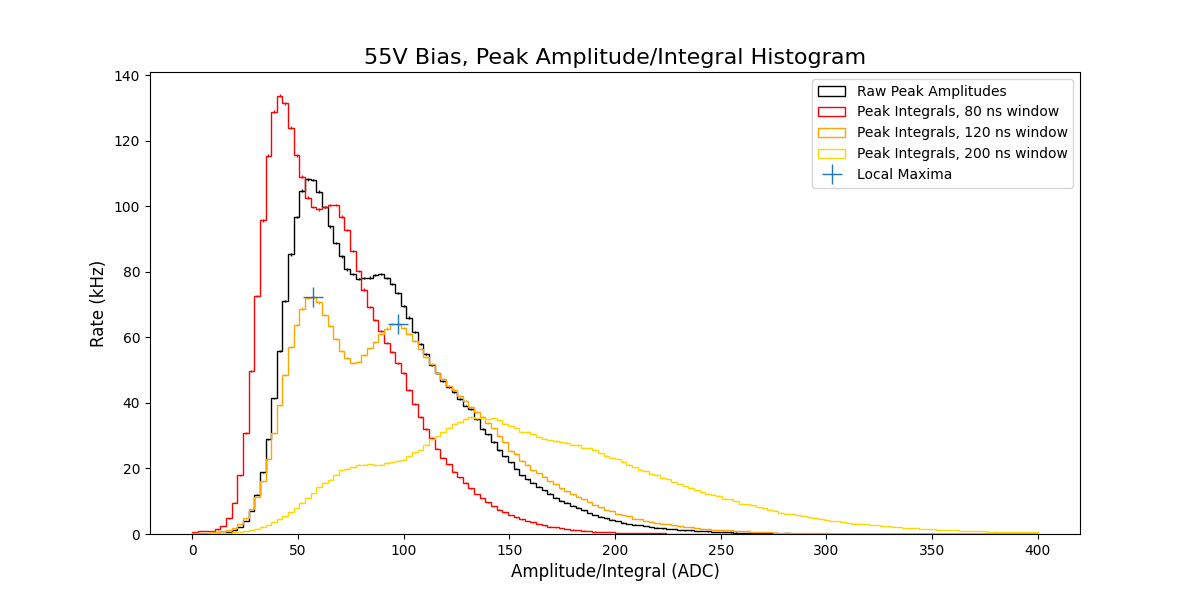

SPE Raw Amplitude: 54.67
Total PE Rate (raw peaks), sum(rate*PE amp): 5088.2 kHz

Integer PE Amplitude (short window): 41.3*5.0
SPE Charge: 206.67
Total PE Rate, sum(rate*PE amp): 4952.7 kHz

Integer PE Amplitude (medium window): 57.3*5.0
SPE Charge: 286.67
Total PE Rate, sum(rate*PE amp): 4558.1 kHz

PE Amplitude spacing (medium window): 40.0*5.0
SPE Charge: 200.00
Total PE Rate, sum(rate*PE amp): 5397.0 kHz

Integer PE Amplitude (long window): 66.0*5.0
SPE Charge: 330.00
Total PE Rate, sum(rate*PE amp): 4903.9 kHz



In [44]:

mybins = 150
myrange = (0,400)
myreduction = 0.2 # divide integrals by ~5 so distribution can be visually compared to raw peak amplitude distribution

plt.close()
rawpks_s, bins, bars = plt.hist(np.concatenate(rawpeaks),weights=[10/totsamples]*len(np.concatenate(rawpeaks)),bins=mybins,range=myrange,histtype="step",label="Raw Peak Amplitudes",color='black')
amplitude = bins[:-1]*0.5+bins[1:]*0.5
plt.errorbar(amplitude, rawpks_s, yerr=np.sqrt(rawpks_s*10/totsamples),
            linewidth=0, elinewidth=1,color='black')

intpks_s, bins, bars = plt.hist(np.concatenate(intpeaks_s)*myreduction,weights=[10/totsamples]*len(np.concatenate(intpeaks_s)),
                                bins=mybins,range=myrange,histtype="step",label=f"Peak Integrals, {(time[mywindow[0]]-time[0])*1000:.0f} ns window",color='red')
plt.errorbar(amplitude, intpks_s, yerr=np.sqrt(intpks_s*10/totsamples),
            linewidth=0, elinewidth=1,color='red')

intpks_m, bins, bars = plt.hist(np.concatenate(intpeaks_m)*myreduction,weights=[10/totsamples]*len(np.concatenate(intpeaks_m)),
                                bins=mybins,range=myrange,histtype="step",label=f"Peak Integrals, {(time[mywindow[1]]-time[0])*1000:.0f} ns window",color='orange')
plt.errorbar(amplitude, intpks_m, yerr=np.sqrt(intpks_m*10/totsamples),
            linewidth=0, elinewidth=1,color='orange')

intpks_l, bins, bars = plt.hist(np.concatenate(intpeaks_l)*myreduction,weights=[10/totsamples]*len(np.concatenate(intpeaks_l)),
                                bins=mybins,range=myrange,histtype="step",label=f"Peak Integrals, {(time[mywindow[2]]-time[0])*1000:.0f} ns window",color='gold')
plt.errorbar(amplitude, intpks_l, yerr=np.sqrt(intpks_l*10/totsamples),
            linewidth=0, elinewidth=1,color='gold')

#peaks2,props2 = find_peaks(intpks_s,height=0,width=5,prominence=1,distance=5)
SPEcharge_s = amplitude[np.argmax(intpks_s)]
SPEcharge_m = amplitude[np.argmax(intpks_m)]
SPEcharge_l = amplitude[np.argmax(intpks_l)]/2
peaks2,props2 = find_peaks(intpks_m,height=0,width=5,prominence=3,distance=5)

plt.plot(amplitude[peaks2],intpks_m[peaks2],linestyle="",marker="+",markersize=15,label="Local Maxima")
#plt.yscale("log")
plt.legend()
plt.title("55V Bias, Peak Amplitude/Integral Histogram", size=16)
plt.xlabel("Amplitude/Integral (ADC)", size=12)
plt.ylabel("Rate (kHz)", size=12)
plt.show()

print(f"SPE Raw Amplitude: {amplitude[np.argmax(rawpks_s)]:.2f}")
print(f"Total PE Rate (raw peaks), sum(rate*PE amp): {sum(rawpks_s*amplitude)/amplitude[np.argmax(rawpks_s)]:.1f} kHz\n")

print(f"Integer PE Amplitude (short window): {SPEcharge_s:.1f}*{1/myreduction:.1f}")
print(f"SPE Charge: {SPEcharge_s/myreduction:.2f}")
print(f"Total PE Rate, sum(rate*PE amp): {sum(intpks_s*amplitude/SPEcharge_s):.1f} kHz\n")

print(f"Integer PE Amplitude (medium window): {SPEcharge_m:.1f}*{1/myreduction:.1f}")
print(f"SPE Charge: {SPEcharge_m/myreduction:.2f}")
print(f"Total PE Rate, sum(rate*PE amp): {sum(intpks_m*amplitude/SPEcharge_m):.1f} kHz\n")

print(f"PE Amplitude spacing (medium window): {amplitude[peaks2][1]-amplitude[peaks2][0]:.1f}*{1/myreduction:.1f}")
print(f"SPE Charge: {(amplitude[peaks2][1]-amplitude[peaks2][0])/myreduction:.2f}")
amplitude_offset = 2*amplitude[peaks2][0] - amplitude[peaks2][1]
print(f"Total PE Rate, sum(rate*PE amp): {sum(intpks_m*(amplitude-amplitude_offset)/(amplitude[peaks2][1]-amplitude[peaks2][0])):.1f} kHz\n")

# also want to treat the dark signal the same as the bright signal
    # dcoffset and divide
    # original script only saved averages and stdevs, need to re-analyze

print(f"Integer PE Amplitude (long window): {SPEcharge_l:.1f}*{1/myreduction:.1f}")
print(f"SPE Charge: {SPEcharge_l/myreduction:.2f}")
print(f"Total PE Rate, sum(rate*PE amp): {sum(intpks_l*amplitude/SPEcharge_l):.1f} kHz\n")

In [45]:
#### Initialize data structure to save results

try: 
    mycalibrations
except NameError:
    mycalibrations = np.array([[int(inputfile.file_path[-9:-5]),
                                sum(intpks_m*(amplitude-amplitude_offset)/(amplitude[peaks2][1]-amplitude[peaks2][0])),
                                (amplitude[peaks2][1]-amplitude[peaks2][0])/myreduction]])
else:
    if (int(inputfile.file_path[-9:-5]) not in (mycalibrations)): 
        mycalibrations = np.append(mycalibrations,np.array([[int(inputfile.file_path[-9:-5]),
                                                             sum(intpks_m*(amplitude-amplitude_offset)/(amplitude[peaks2][1]-amplitude[peaks2][0])),
                                                             SPEcharge_m/myreduction]]),axis=0)
    else: print("Calbiration output already defined with entry for that file!\n",mycalibrations)

In [46]:
#mycalibrations[0][0] = 0
mycalibrations

array([[1919.        , 5396.97196671,  200.        ]])